In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Data
df = pd.read_csv('resources/DATA.csv')

# Target Columns
target_columns = [
    'HN',
    'HNE',
    'HE',
    'HSE',
    'HS',
    'HSW',
    'HW',
    'HNW',
    'MN',
    'MNE',
    'ME',
    'MSE',
    'MS',
    'MSW',
    'MW',
    'MNW',
    'LN',
    'LNE',
    'LE',
    'LSE',
    'LS',
    'LSW',
    'LW',
    'LNW'
]

# Convert colors to numbers
map = {
    'gray': 0,
    'green': 1,
    'yellow': 2,
    'orange': 3,
    'red': 4,
    'black': 5,    
}

# For target columns
for col in target_columns:
    df[col] = df[col].map(map)

# Make a new column be the max risk of the target columns
df['max_risk'] = df[target_columns].max(axis=1)
target_columns += ['max_risk']
    
input_columns = [
    'ALTA_Precip_(tenths_mm)',
    'ALTA_Snowfall_(mm)',
    'ALTA_Snow_Depth_(mm)',
    'ALTA_Max_Temp_(tenths_C)',
    'ALTA_Min_Temp_(tenths_C)',
    'ALTA_Multiday_Prec_Days',
    'ALTA_Multiday_Snowfall_Days',
    'ALTA_Multiday_Prec_Days_(tenths_mm)',
    'ALTA_Multiday_Snowfall',
    'ALTA_Temp_at_Observation_(tenths_C)',
    'ALTA_Fog_Ice_Fog',
    'ALTA_Heavy_Fog_Freezing_Fog',
    'ALTA_Ice_Pellets_Sleet',
    'ALTA_Hail',
    'ALTA_Glaze_Rime',
    'ALTA_Weather_Type_07',
    'ALTA_Smoke_Haze',
    'ALTA_Blowing_Drifting_Snow',
    'ALTA_High_Winds',
    'ALTA_Snow_Pellets_Ice_Crystals',
    'BRIGHTON_Precip_(tenths_mm)',
    'BRIGHTON_Snow_Depth_(mm)',
    'BRIGHTON_Max_Temp_(tenths_C)',
    'BRIGHTON_Min_Temp_(tenths_C)',
    'BRIGHTON_Avg_Daily_Temp_(tenths_C)',
    'BRIGHTON_Temp_at_Observation_(tenths_C)',
    'BRIGHTON_Snow_on_Ground_(tenths_mm)',
    'THAYNES_Precip_(tenths_mm)',
    'THAYNES_Snow_Depth_(mm)',
    'THAYNES_Max_Temp_(tenths_C)',
    'THAYNES_Min_Temp_(tenths_C)',
    'THAYNES_Avg_Daily_Temp_(tenths_C)',
    'THAYNES_Temp_at_Observation_(tenths_C)',
    'THAYNES_Snow_on_Ground_(tenths_mm)',
    'PARLEY_SUMMIT_Precip_(tenths_mm)',
    'PARLEY_SUMMIT_Snow_Depth_(mm)',
    'PARLEY_SUMMIT_Max_Temp_(tenths_C)',
    'PARLEY_SUMMIT_Min_Temp_(tenths_C)',
    'PARLEY_SUMMIT_Temp_at_Observation_(tenths_C)',
    'PARLEY_SUMMIT_Snow_on_Ground_(tenths_mm)'
]

# add data from previous day
for col in target_columns:
    input_columns.append(col + '_prev')
    df[col + '_prev'] = df[col].shift(1)

# Fill NA with 0
df = df.fillna(0)

X = df[input_columns]
y = df['max_risk']

In [11]:
import torch

In [66]:
def split_into_chunks(X, y, chunk_size=16):
    # print(X.shape, y.shape)
    X_chunks = []
    y_chunks = []
    for i in range(len(X) - chunk_size):
        X_chunks.append(X[i:i+chunk_size])
        y_chunks.append(y[i:i+chunk_size])
    X_chunks = np.array(X_chunks)
    y_chunks = np.array(y_chunks)
    return X_chunks, y_chunks

X = df[input_columns]
y = df['max_risk']
x_chunks, y_chunks = split_into_chunks(X, y)
X_train, X_test, y_train, y_test = train_test_split(x_chunks, y_chunks, test_size=0.2)

def get_random_chunk(X, y, chunk_size=16):
    # print("Type: ", type(X), type(y))
    # print(X.shape, y.shape)
    i = np.random.randint(0, len(X) - chunk_size)
    return X[i], y[i]
    

def get_random_batch(xchunks, ychunks, batch_size=16):
    # print("Type: ", type(xchunks), type(ychunks))
    # print(xchunks.shape, ychunks.shape)
    X_batch = []
    y_batch = []
    for i in range(batch_size):
        # print(i)
        X_chunk, y_chunk = get_random_chunk(xchunks, ychunks)
        X_batch.append(X_chunk)
        y_batch.append(y_chunk)
    return np.array(X_batch), np.array(y_batch)

In [67]:
print(X_train.shape, y_train.shape)

(1221, 16, 65) (1221, 16)


In [68]:
a, b = get_random_chunk(X_train, y_train)
print(a.shape, b.shape)

(16, 65) (16,)


In [69]:
a, b = get_random_batch(X_train, y_train, batch_size=32)
print(a.shape, b.shape)

(32, 16, 65) (32, 16)


In [75]:
import torch
# device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
device = torch.device("cpu")

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(out[:, -1, :])
        return out, h
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(device)
    
def train(model, optimizer, criterion, X_train, y_train, batch_size=32):
    model.train()
    optimizer.zero_grad()
    h = model.init_hidden(batch_size)
    # print(X_train.shape, h.shape)
    output, h = model(X_train, h)
    
    y_train = y_train[:, -1]
    # print(output.shape, y_train.shape)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, X_test, y_test, batch_size=32):
    model.eval()
    h = model.init_hidden(batch_size)
    output, h = model(X_test, h)
    y_test = y_test[:, -1]
    y_pred = torch.argmax(output, dim=1)
    return accuracy_score(y_test, y_pred)

iterations = 3000
batch_size = 32
chunk_size = 32
hidden_size = 64
learning_rate = 0.0001
num_layers = 8

model = GRU(65, hidden_size, 6, num_layers=num_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

losses = []
accuracies = []
validation_losses = []
validation_accuracies = []

X = df[input_columns]
y = df['max_risk']
x_chunks, y_chunks = split_into_chunks(X, y)
X_train, X_test, y_train, y_test = train_test_split(x_chunks, y_chunks, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

for i in range(iterations):
    x, y = get_random_batch(X_train, y_train, batch_size=batch_size)
    xt = torch.tensor(x).to(device).to(torch.float32)
    yt = torch.tensor(y).to(device).to(torch.long)
    loss = train(model, optimizer, criterion, xt, yt, batch_size=batch_size)
    losses.append(loss)
    acc = evaluate(model, xt, yt, batch_size=batch_size)
    accuracies.append(acc)
    print(f'Iteration: {i}, Loss: {loss}, Accuracy: {acc}')
    if i % 10 == 0:
        x, y = get_random_batch(X_test, y_test, batch_size=batch_size)
        yt = torch.tensor(y).to(device).to(torch.long)
        xt = torch.tensor(x).to(device).to(torch.float32)
        loss = train(model, optimizer, criterion, xt, yt, batch_size=batch_size)
        validation_losses.append(loss)
        acc = evaluate(model, xt, yt, batch_size=batch_size)
        validation_accuracies.append(acc)
        print(f'Validation Loss: {loss}, Validation Accuracy: {acc}')


(1221, 16, 65) (1221, 16)
(306, 16, 65) (306, 16)
Iteration: 0, Loss: 1.8117440938949585, Accuracy: 0.0
Validation Loss: 1.85682213306427, Validation Accuracy: 0.0
Iteration: 1, Loss: 1.8219568729400635, Accuracy: 0.03125
Iteration: 2, Loss: 1.8480440378189087, Accuracy: 0.0
Iteration: 3, Loss: 1.8241840600967407, Accuracy: 0.0
Iteration: 4, Loss: 1.8403232097625732, Accuracy: 0.0
Iteration: 5, Loss: 1.8035205602645874, Accuracy: 0.0
Iteration: 6, Loss: 1.8424105644226074, Accuracy: 0.1875
Iteration: 7, Loss: 1.8065218925476074, Accuracy: 0.3125
Iteration: 8, Loss: 1.8133814334869385, Accuracy: 0.28125
Iteration: 9, Loss: 1.7991015911102295, Accuracy: 0.3125
Iteration: 10, Loss: 1.817518711090088, Accuracy: 0.21875
Validation Loss: 1.796964168548584, Validation Accuracy: 0.28125
Iteration: 11, Loss: 1.772990345954895, Accuracy: 0.34375
Iteration: 12, Loss: 1.7838468551635742, Accuracy: 0.28125
Iteration: 13, Loss: 1.7435119152069092, Accuracy: 0.4375
Iteration: 14, Loss: 1.796602964401

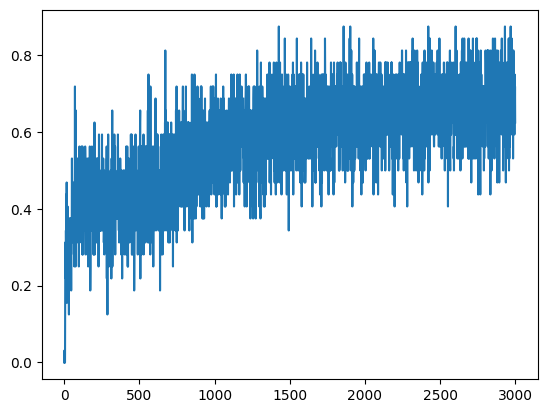

In [76]:
plt.plot(accuracies)

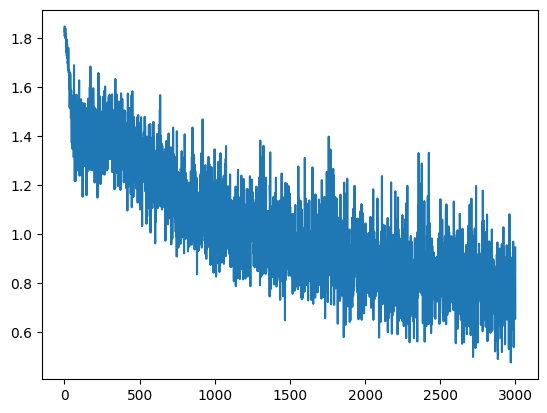

In [77]:
import matplotlib.pyplot as plt
plt.plot(losses)

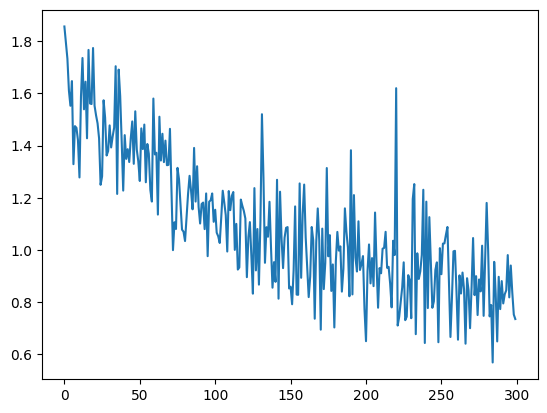

In [78]:
import matplotlib.pyplot as plt
plt.plot(validation_losses)

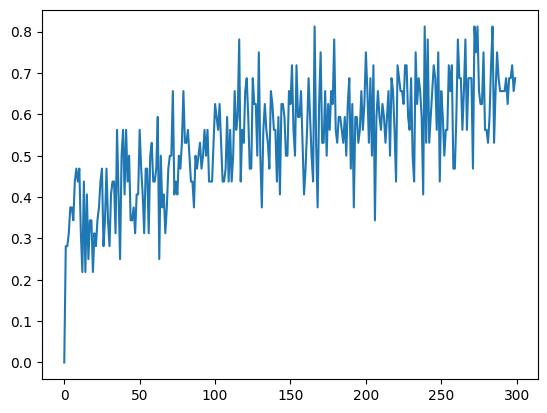

In [79]:
plt.plot(validation_accuracies)